In [17]:
import pandas as pd
import seaborn as sns
%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import color_demo
pd.set_option('display.max_columns', None)
sns.set()
import random
import corner
import numpy as np
from om10 import plotting
from astropy.table import Table

Populating the interactive namespace from numpy and matplotlib


In [18]:
# Read the data
pd.set_option('display.max_columns', None)
qsos = pd.read_csv("../../StatisticalMethods/examples/SDSScatalog/data/qso10000.csv",index_col=0)
# Clean out extreme colors and bad magnitudes:
qsos = qsos[(qsos["dered_r"] > -9999) & (qsos["g_r_color"] > -10) & (qsos["g_r_color"] < 10)]
# Change to Numpy Array because it is easier to manipulate
qso = qsos.as_matrix()

In [19]:
# color the quasars with the method written
z=[]
i=[]
gr=[]
ri=[]
iz=[]
for number in range(150):
    # key : ra dec dered_u dered_g dered_r dered_i dered_z mag_u mag_g mag_r 
    # mag_i mag_z spec_z u_g_color g_r_color r_i color i_z carlar ...
    rand = random.randint(0, len(qso)-1)
    redshift = qso[rand][12]
    r_calc, g_calc, i_calc, z_calc = color_demo.CalculateMagnitude('../data/', 'source', redshift)
    g_r = g_calc-r_calc
    r_i = r_calc-i_calc
    i_z = i_calc-z_calc
    z.append(redshift)
    i.append(i_calc)
    gr.append(g_r)
    ri.append(r_i)
    iz.append(i_z)

In [20]:
# Initialize everything to make a cornerplot
# Rather than changing db.py to enable reading text files I just did in Jupyter

axis_labels = {}
axis_labels['ZLENS'] = '$redshift$'
axis_labels['MAGI_Q'] = '$I$'
axis_labels['GR'] = '$G-R$'
axis_labels['RI'] = '$R-I$'
axis_labels['IZ'] = '$I-Z$'

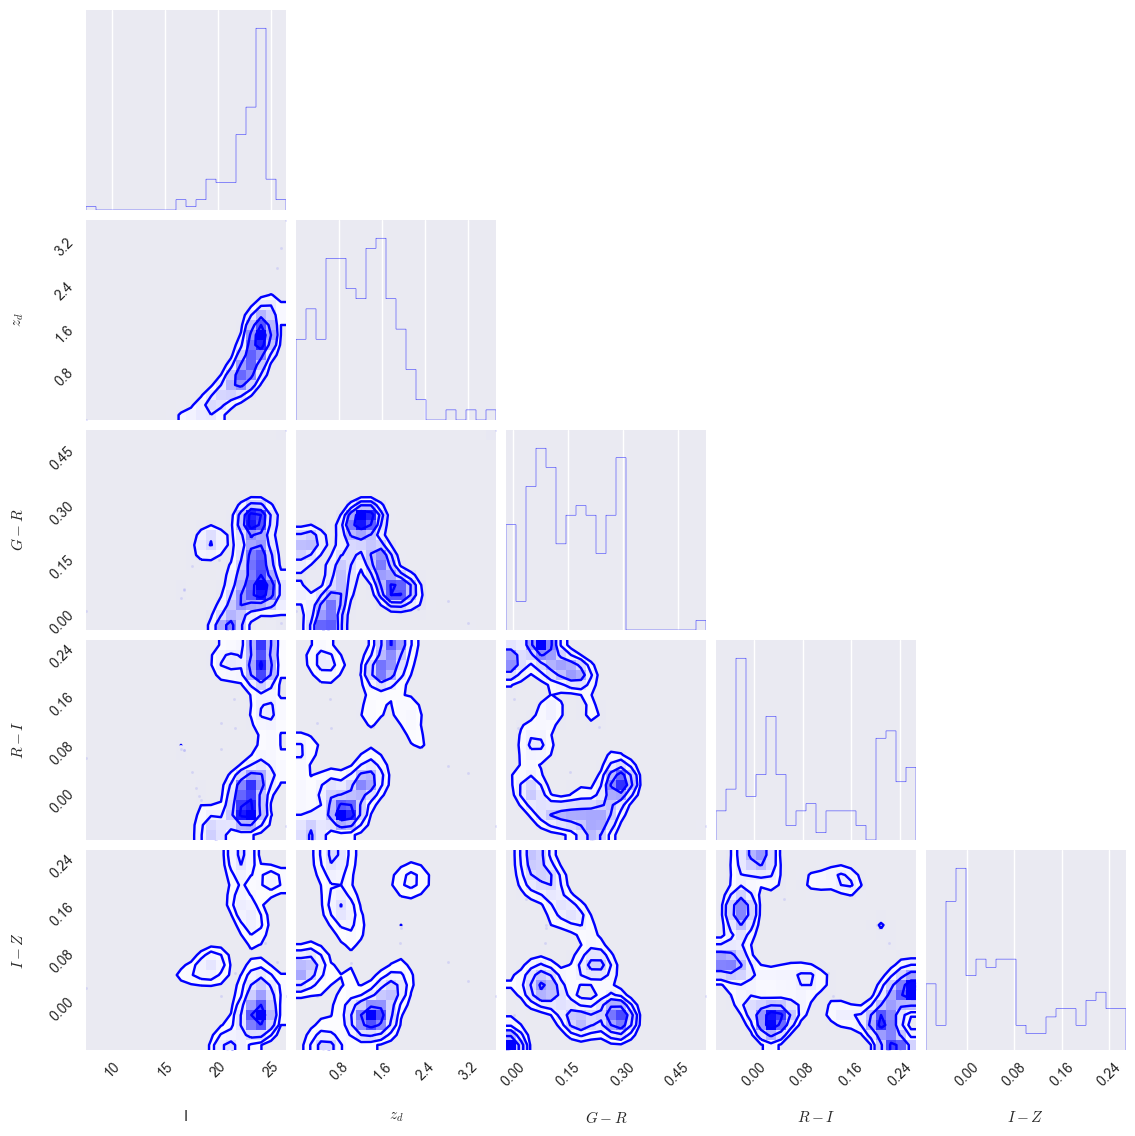

In [23]:
matplotlib.rc('text', usetex=False)
# plot the above colored lens
data = Table({'MAGI_Q': i, 'ZLENS': z, 'GR': gr, 'RI': ri, 'IZ': iz}, names=['MAGI_Q', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('MAGI_Q','ZLENS', 'GR', 'RI', 'IZ'))
fig1 = corner.corner(features, labels=labels, color='blue', smooth=1.0)

In [ ]:
z = qsos["spec_z"].as_matrix()
i = qsos["mag_i"].as_matrix()
gr = qsos["g_r_color"].as_matrix()
ri = qsos["r_i_color"].as_matrix()
iz = qsos["i_z_color"].as_matrix()

In [ ]:
matplotlib.rc('text', usetex=False)
# plot the above colored lens
data = Table({'MAGI': i, 'ZLENS': z, 'GR': gr, 'RI': ri, 'IZ': iz}, names=['MAGI', 'ZLENS', 'GR', 'RI', 'IZ'])
features, label = plotting.extract_features(data, ('MAGI','ZLENS', 'GR', 'RI', 'IZ'))
corner.corner(features, labels=labels, color='red', smooth=1.0, fig=fig1)